In [86]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [87]:
df = pd.read_csv('data/Default.csv')

# We set the first column as the index since it is not a variable
df.set_index('Unnamed: 0', inplace=True)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
# We transform 'No' to 0 and 'Yes' to 1
df['default_enc'] = df.default.factorize()[0] # df['default'].factorize() returns a tuple, we only need the first element
df['student_enc'] = df.student.factorize()[0]
df[['default_enc','default','student_enc','student']].head()
df.head(3)

,default,student,balance,income,default_enc,student_enc
Unnamed: 0,,,,,,
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


In [88]:
# A look to the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      10000 non-null  object 
 1   student      10000 non-null  object 
 2   balance      10000 non-null  float64
 3   income       10000 non-null  float64
 4   default_enc  10000 non-null  int64  
 5   student_enc  10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 546.9+ KB


In [89]:
# We remove null values for the balance and income variables
df.dropna(subset=['balance', 'income'], inplace=True)  # Inplace=True modifies the DataFrame

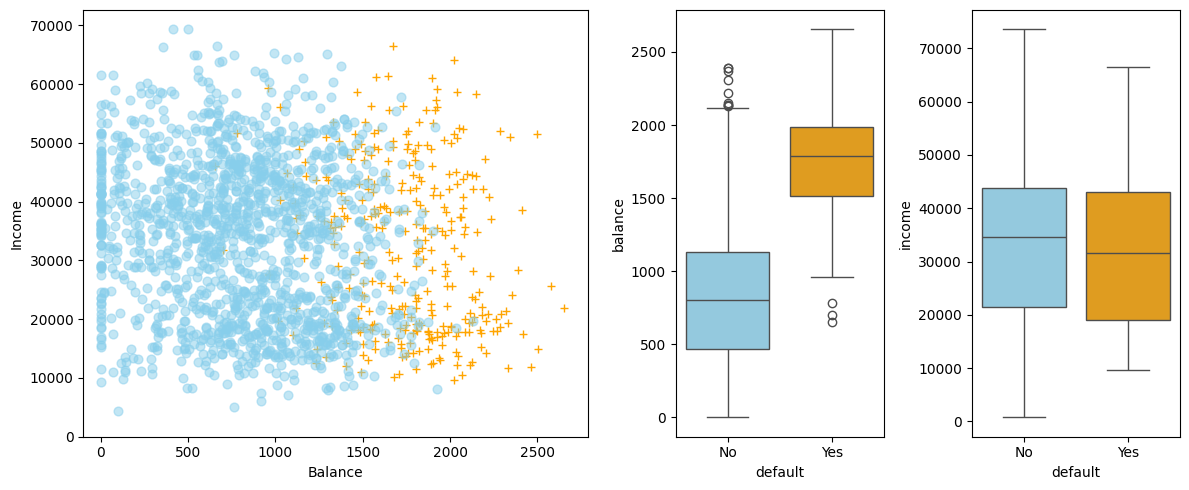

In [90]:
# Let's have a look to the data
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default_enc == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default_enc == 1]
df_ = pd.concat([df_no, df_yes])

ax1.scatter(x=df_[df_.default == 'Yes'].balance, y=df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)

ax1.scatter(x=df_[df_.default == 'No'].balance, y=df_[df_.default == 'No'].income, alpha=.5, s=40, c='skyblue', marker='o',)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'skyblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, hue = 'default', palette=c_palette, legend=False)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, hue = 'default', palette=c_palette, legend=False)
gs.tight_layout(plt.gcf())

## Train and test split
We now work with balance as X and default as y

In [91]:
# We assign the variables X and y
x = df['balance'].values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df['default_enc']
print(x)
print(f"\n\n\n{df.balance}")

[[ 729.52649521]
 [ 817.18040656]
 [1073.54916401]
 ...
 [ 845.41198922]
 [1569.00905338]
 [ 200.92218263]]



Unnamed: 0
1         729.526495
2         817.180407
3        1073.549164
4         529.250605
5         785.655883
            ...     
9996      711.555020
9997      757.962918
9998      845.411989
9999     1569.009053
10000     200.922183
Name: balance, Length: 10000, dtype: float64


In [92]:
# We now divide in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
print(X_train.shape)
print(X_test.shape)

(8000, 1)
(2000, 1)


In [94]:
y_train.shape

(8000,)

## Fit the model

In [95]:
# Fit the model
clf = skl_lm.LogisticRegression()
clf.fit(X_train,y_train)


LogisticRegression()

In [96]:
x_proba = clf.predict_proba([X_train[0]])
x_pred = clf.predict([X_train[0]])

print('Class Order:', clf.classes_)
print('Prob:', x_proba)
print('Model prediction:', x_pred)

Class Order: [0 1]
Prob: [[0.99780427 0.00219573]]
Model prediction: [0]


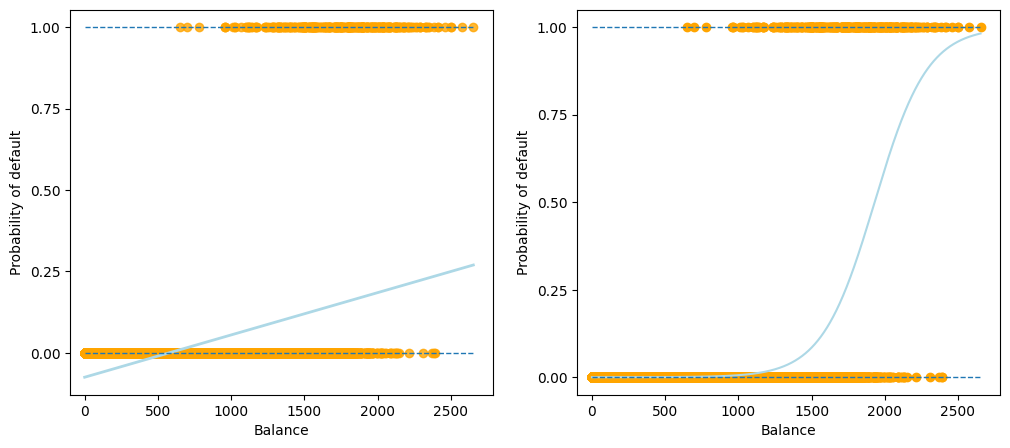

In [97]:
X_space = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
prob = clf.predict_proba(X_space)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(x=df.balance, y=df.default_enc, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(x, y, color='orange')
ax2.plot(X_space, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [98]:
# Let's suppose we have a new observation with balance = 2500
# We can calculate the probability of default
new_balance_obs = 2000
prob_new_obs = clf.predict_proba([[new_balance_obs]])[:,1][0]
print(f'Prob of default with balance = {str(new_balance_obs)}: {round(prob_new_obs*100,2)}%')

Prob of default with balance = 2000: 59.52%


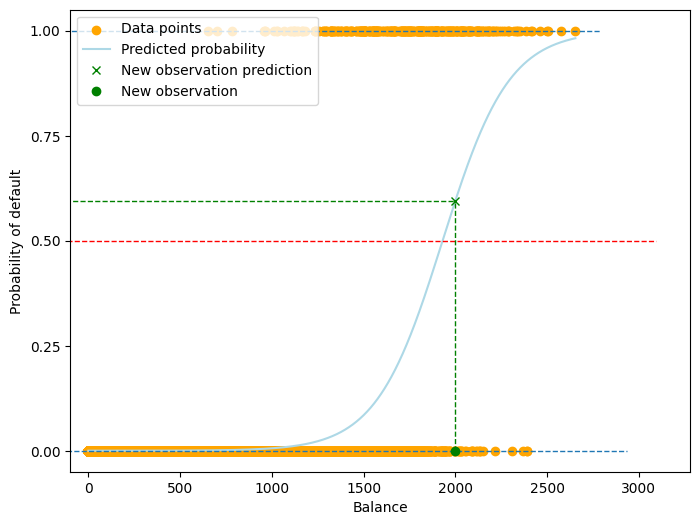

In [99]:
# Plot the graph
plt.figure(figsize=(8, 6))

# Scatter plot and line plot
plt.scatter(x, y, color='orange', label='Data points')
plt.plot(X_space, prob[:, 1], color='lightblue', label='Predicted probability')

# Add horizontal lines upper bound
plt.hlines(1, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines lower bound
plt.hlines(0, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines, the discriminant boundary
plt.hlines(0.5, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1, colors='red')
# Add new observation
plt.vlines(new_balance_obs, ymin=0, ymax=prob_new_obs, linestyles='dashed', lw=1, colors='green')
plt.hlines(prob_new_obs, xmin=plt.gca().get_xlim()[0], xmax=new_balance_obs, linestyles='dashed', lw=1, colors='green')
plt.plot(new_balance_obs, prob_new_obs, 'gx', label='New observation prediction')
plt.plot(new_balance_obs, 0, 'go', label='New observation')


# Set labels and ticks
plt.ylabel('Probability of default')
plt.xlabel('Balance')
plt.yticks([0, 0.25, 0.5, 0.75, 1.])
plt.xlim(xmin=-100)

# Add legend
plt.legend(loc='upper left')

# Show plot
plt.show()

In [101]:
# Look at the parameters
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

classes:  [0 1]
coefficients:  [[0.00553357]]
intercept : [-10.68173157]


In [102]:
# statsmodels needs the intercept to be included in the X_train
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2()# .tables[1]

Optimization terminated successfully.
         Current function value: 0.079083
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.458      
Date:               2025-02-25 22:13 AIC:              1269.3267  
No. Observations:   8000             BIC:              1283.3011  
Df Model:           1                Log-Likelihood:   -632.66    
Df Residuals:       7998             LL-Null:          -1166.9    
Converged:          1.0000           LLR p-value:      2.3216e-234
No. Iterations:     10.0000          Scale:            1.0000     
--------------------------------------------------------------------
         Coef.     Std.Err.      z       P>|z|     [0.025     0.975]
--------------------------------------------------------------------
const   -10.6817     0.4052   -26.3632   0.0000   -11.4759   -9.8876
0         0.0055     0.0002    22.3104   0.0000     0.0050    0.0060
==================================================================

"""

# Odds and probability

# Multiple Logistic Regression

In [103]:
x = df[['balance', 'income', 'student_enc']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [111]:
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078244
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6275,0.539,-19.723,0.000,-11.684,-9.571
balance,0.0057,0.000,22.124,0.000,0.005,0.006
income,-2.856e-06,9.15e-06,-0.312,0.755,-2.08e-05,1.51e-05
student_enc,-0.6480,0.263,-2.468,0.014,-1.163,-0.133


# Confusion Matrix

In [105]:
X_test_w_intercept = sm.add_constant(X_test)
pred = est.predict(X_test_w_intercept)
y_pred = (pred > 0.5).astype(int)
y_pred



Unnamed: 0
8355    0
2011    0
8930    0
682     0
1380    0
       ..
5483    0
3640    0
36      0
7431    0
5991    0
Length: 2000, dtype: int64

In [106]:
y_train.value_counts()

default_enc
0    7734
1     266
Name: count, dtype: int64

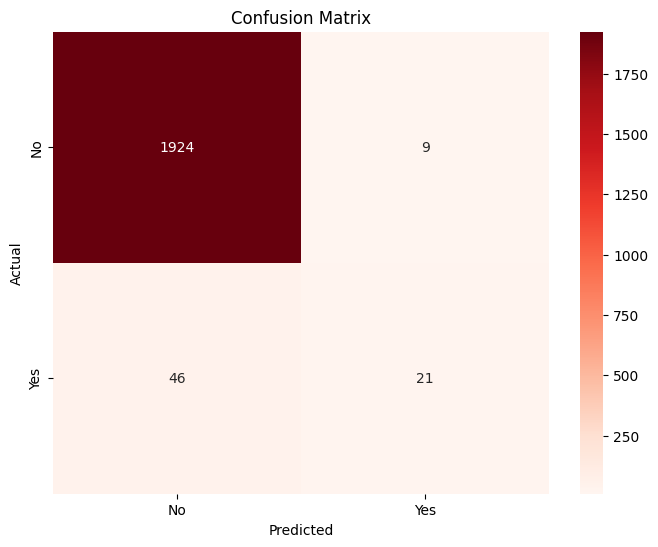

In [107]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title('Confusion Matrix')
plt.show()

In [114]:

def evaluate_classification_performance(y_test, y_pred):
    """
    Evaluate and print out standard classification metrics.
    """
    # Compute the confusion matrix
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate specificity = TN / (TN + FP)
    specificity = tn / (tn + fp)
    
    # Calculate other metrics using scikit-learn
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    # FPR = 1 - specificity
    fpr = 1 - specificity
    
    # Print all metrics in a neat format
    print(f"Accuracy:    {accuracy:.2f}")
    print(f"Precision:   {precision:.2f}")
    print(f"Recall:      {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"FPR:         {fpr:.2f}")
    print(f"F1 Score:    {f1:.2f}")
    
    # Optionally return metrics in a dictionary if needed
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'fpr': fpr,
        'f1_score': f1
    }

In [115]:
# Calculate accuracy
metrics_dict = evaluate_classification_performance(y_test, y_pred)


Accuracy:    0.97
Precision:   0.70
Recall:      0.31
Specificity: 1.00
FPR:         0.00
F1 Score:    0.43


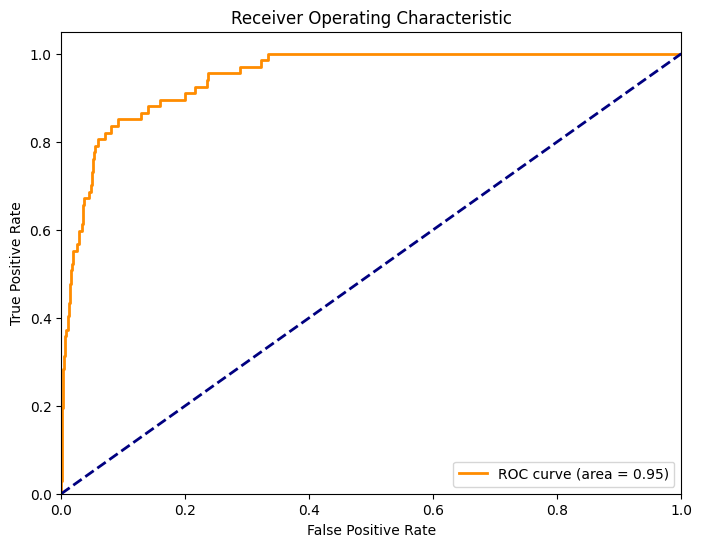

In [109]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Calculate AUC
roc_auc = roc_auc_score(y_test, pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [110]:
# Calculate the Gini coefficient
gini = 2 * roc_auc - 1
print('Gini coefficient: %.2f' % gini)

Gini coefficient: 0.90
